In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
# Column names (NASA CMAPSS standard)
columns = [
    'engine_id', 'cycle',
    'op_setting_1', 'op_setting_2', 'op_setting_3'
] + [f'sensor_{i}' for i in range(1, 22)]

# Load TXT file
df = pd.read_csv(
    'train_FD001.txt',
    sep='\s+',
    header=None,
    names=columns
)

df.head()


C:\Users\ALI MUHAMMAD\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [2]:
#Convert TXT → CSV (Requirement)
df.to_csv('train_FD001.csv', index=False)


In [4]:
# Forward fill then median fill
df.fillna(method='ffill', inplace=True)
df.fillna(df.median(), inplace=True)


C:\Users\ALI MUHAMMAD\AppData\Local\Temp\ipykernel_16064\2146119329.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
df.isna().sum()


engine_id       0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64

In [6]:
#Outlier Removal (IQR Method)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | 
          (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [7]:
#Create RUL (Remaining Useful Life)
max_cycle = df.groupby('engine_id')['cycle'].max()

df['RUL'] = df.apply(
    lambda row: max_cycle[row['engine_id']] - row['cycle'],
    axis=1
)


In [8]:
#Create Binary Fault Label
df['fault'] = df['RUL'].apply(lambda x: 1 if x <= 20 else 0)


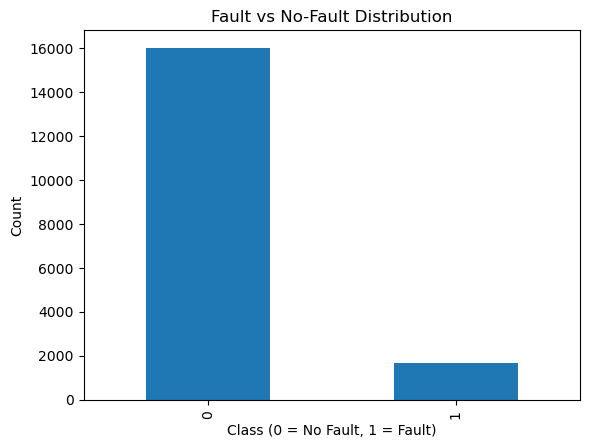

In [9]:
#VISUALIZATION 1: Fault vs No-Fault Distribution
df['fault'].value_counts().plot(kind='bar')
plt.title('Fault vs No-Fault Distribution')
plt.xlabel('Class (0 = No Fault, 1 = Fault)')
plt.ylabel('Count')
plt.show()


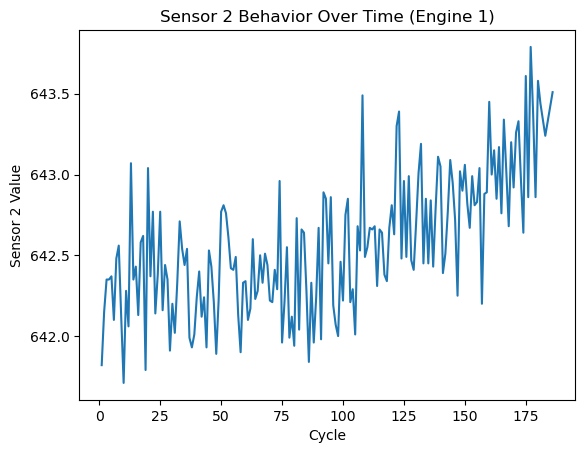

In [10]:
#VISUALIZATION 2: Sensor Behavior Over Time
engine_1 = df[df['engine_id'] == 1]

plt.figure()
plt.plot(engine_1['cycle'], engine_1['sensor_2'])
plt.xlabel('Cycle')
plt.ylabel('Sensor 2 Value')
plt.title('Sensor 2 Behavior Over Time (Engine 1)')
plt.show()


In [11]:
#Feature Engineering (Rolling Mean & Std)
window = 5

sensor_cols = [col for col in df.columns if 'sensor_' in col]

for col in sensor_cols:
    df[f'{col}_rolling_mean'] = df[col].rolling(window).mean()
    df[f'{col}_rolling_std'] = df[col].rolling(window).std()

df.dropna(inplace=True)


In [12]:
engine_1 = df[df['engine_id'] == 1]


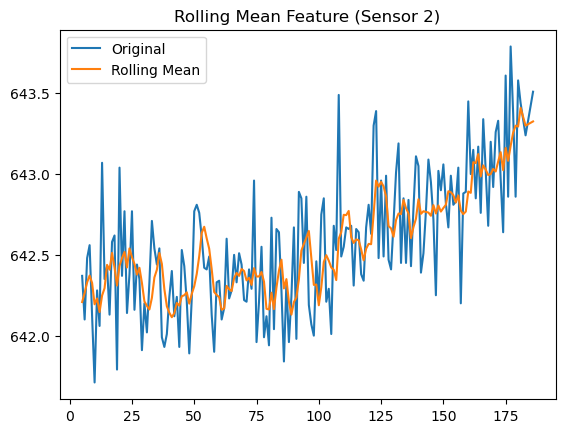

In [13]:
#VISUALIZATION 3: Rolling Mean vs Original Sensor
plt.figure()
plt.plot(engine_1['cycle'], engine_1['sensor_2'], label='Original')
plt.plot(engine_1['cycle'], engine_1['sensor_2_rolling_mean'], label='Rolling Mean')
plt.legend()
plt.title('Rolling Mean Feature (Sensor 2)')
plt.show()


In [14]:
df.to_csv('train_FD001_final.csv', index=False)


In [15]:
#Train-Test Split

X = df.drop(['fault', 'RUL'], axis=1)
y = df['fault']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
#Train Binary Classification Model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
#Model Evaluation (Precision & Recall)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3200
           1       0.90      0.78      0.83       334

    accuracy                           0.97      3534
   macro avg       0.94      0.88      0.91      3534
weighted avg       0.97      0.97      0.97      3534



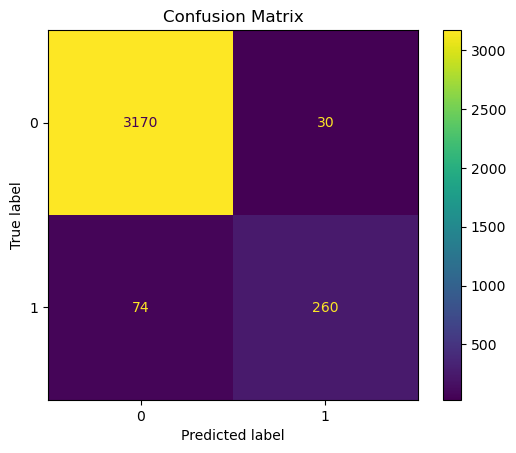

In [18]:
#VISUALIZATION 4: Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()


In [19]:
import joblib

joblib.dump(model, 'fault_detection_model.pkl')


['fault_detection_model.pkl']